In [1]:
import pandas as pd
import numpy as np

THRESHOLD = '10e3' # nM (defined according to ref 1 at 10 uM)

dataset = pd.read_csv('chembl_herg_data.csv', header=0, on_bad_lines='skip',sep=';',dtype="string")

# clean_ds = dataset.loc[:,['Molecule Name',"Molecular Weight","AlogP","Smiles","Standard Type","Standard Relation","Standard Value","Standard Units","pChEMBL Value","Ligand Efficiency BEI","Ligand Efficiency LE","Ligand Efficiency LLE","Ligand Efficiency SEI"]]

smiles_df = dataset.loc[:, ['Smiles', "Standard Value", "Standard Units"]]

# Rows where Standard Value is missing (NaN)
# non_empty_std_value = smiles_df[smiles_df['Standard Value'].notna()]
non_empty_std_value = smiles_df.dropna(how='any')
print(f"Number of rows with non-empty Standard Value: {non_empty_std_value.shape[0]}")
print()

# Optionally inspect first few rows
# Check if all Standard Units are 'nM'
all_nm = non_empty_std_value['Standard Units'].eq('nM').all()
print("All units are 'nM':", all_nm)
print("Unique units:", non_empty_std_value['Standard Units'].unique())
print("Value counts:\n", non_empty_std_value['Standard Units'].value_counts(dropna=False))
# non_empty_std_value
print()
nm_entries = smiles_df[smiles_df['Standard Units'].eq('nM')].copy()
print(f"Entries with Standard Units = 'nM': {nm_entries.shape[0]}")
print(nm_entries.size)
print()

# Filter for IC50 and nM units
ic50_nm = nm_entries.copy()
print(f"Entries with Standard Type = 'IC50' and Standard Units = 'nM': {ic50_nm.shape[0]}")

print(ic50_nm.size)

activity_array = (THRESHOLD+ ">" + ic50_nm['Standard Value'].to_numpy().astype(str))#.astype(str)
# ic50_nm 
print(activity_array)

evaluated_activity = np.fromiter((eval(expr) for expr in activity_array),dtype=bool)

n_active = int(np.count_nonzero(evaluated_activity))
n_inactive = int(evaluated_activity.size - n_active)
print(f"\nFound {n_active} hERG active compounds and {n_inactive} inactive compounds...\n")

clean_df = pd.DataFrame({
    'canonical_smiles': ic50_nm['Smiles'].to_numpy().astype(str),
    'active': evaluated_activity
})

clean_df

Number of rows with non-empty Standard Value: 16640

All units are 'nM': False
Unique units: <StringArray>
['nM', 'ug.mL-1', 'ucm']
Length: 3, dtype: string
Value counts:
 Standard Units
nM         16624
ug.mL-1       13
ucm            3
Name: count, dtype: Int64

Entries with Standard Units = 'nM': 16626
49878

Entries with Standard Type = 'IC50' and Standard Units = 'nM': 16626
49878
['10e3>130.0' '10e3>3140.0' '10e3>25000.0' ... '10e3>100000.0'
 '10e3>62500.0' '10e3>1200.0']

Found 8005 hERG active compounds and 8621 inactive compounds...



,canonical_smiles,active
0,c1ccc(COc2ccc(CCNc3ccncc3)cc2)cc1,True
1,CCN(CC)CCOc1cc(-c2nc(SCC(=O)NC)nc3[nH]cc(C#N)c...,True
2,N#C[C@H]1CCOC[C@@H]1n1cc(C(N)=O)c(Nc2ccc(OC(F)...,False
3,N#C[C@H]1CCOC[C@@H]1n1cc(C(N)=O)c(Nc2ccc(-n3cc...,False
4,Cc1cnc(N2CCC(C3CCN(c4cc(C)nc(C#N)n4)CC3)CC2)cn1,False
...,...,...
16621,O=C(NC1CCOC1)c1n[nH]c2ccc(-c3cccc(F)c3F)cc12,False
16622,Cn1c(=O)cnc2cc(F)c(OCCNC[C@H]3CN(c4cnc5c(n4)NC...,False
16623,Nc1nnc(N2CCC(N3C[C@H](C(=O)N4CCC(F)(F)C4)OC[C@...,False
16624,Nc1nnc(N2CCC(N3C[C@H](N4CCOCC4)C[C@@H]3Cc3ccc(...,False


In [2]:
from qsar_herg_model import HERGQSARModel

print("hERG Cardiotoxicity QSAR Model")
print("=" * 50)

df = clean_df

# Create model instance
model = HERGQSARModel(df, fingerprint_type='morgan', model_type='rf')

hERG Cardiotoxicity QSAR Model
Generating morgan fingerprints...


Processing molecules:  83%|████████▎ | 13875/16626 [00:17<00:03, 766.46it/s][16:53:11] SMILES Parse Error: syntax error while parsing: <NA>
[16:53:11] SMILES Parse Error: check for mistakes around position 1:
[16:53:11] <NA>
[16:53:11] ^
[16:53:11] SMILES Parse Error: Failed parsing SMILES '<NA>' for input: '<NA>'
Processing molecules:  87%|████████▋ | 14459/16626 [00:17<00:02, 819.87it/s][16:53:12] SMILES Parse Error: syntax error while parsing: <NA>
[16:53:12] SMILES Parse Error: check for mistakes around position 1:
[16:53:12] <NA>
[16:53:12] ^
[16:53:12] SMILES Parse Error: Failed parsing SMILES '<NA>' for input: '<NA>'
Processing molecules: 100%|██████████| 16626/16626 [00:20<00:00, 815.48it/s]


Generated feature matrix: (16624, 2048)


Model type set to xgb. Please retrain the model.
Training XGB model with morgan fingerprints...
Training model...
Performing cross-validation...

Cross-validation AUC: 0.851 ± 0.006
Test set AUC: 0.861

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.82      0.79      1724
        True       0.79      0.73      0.76      1601

    accuracy                           0.78      3325
   macro avg       0.78      0.78      0.78      3325
weighted avg       0.78      0.78      0.78      3325

Model Evaluation Results:
AUC Score: 0.861
Accuracy: 0.778
Sensitivity: 0.733
Specificity: 0.821


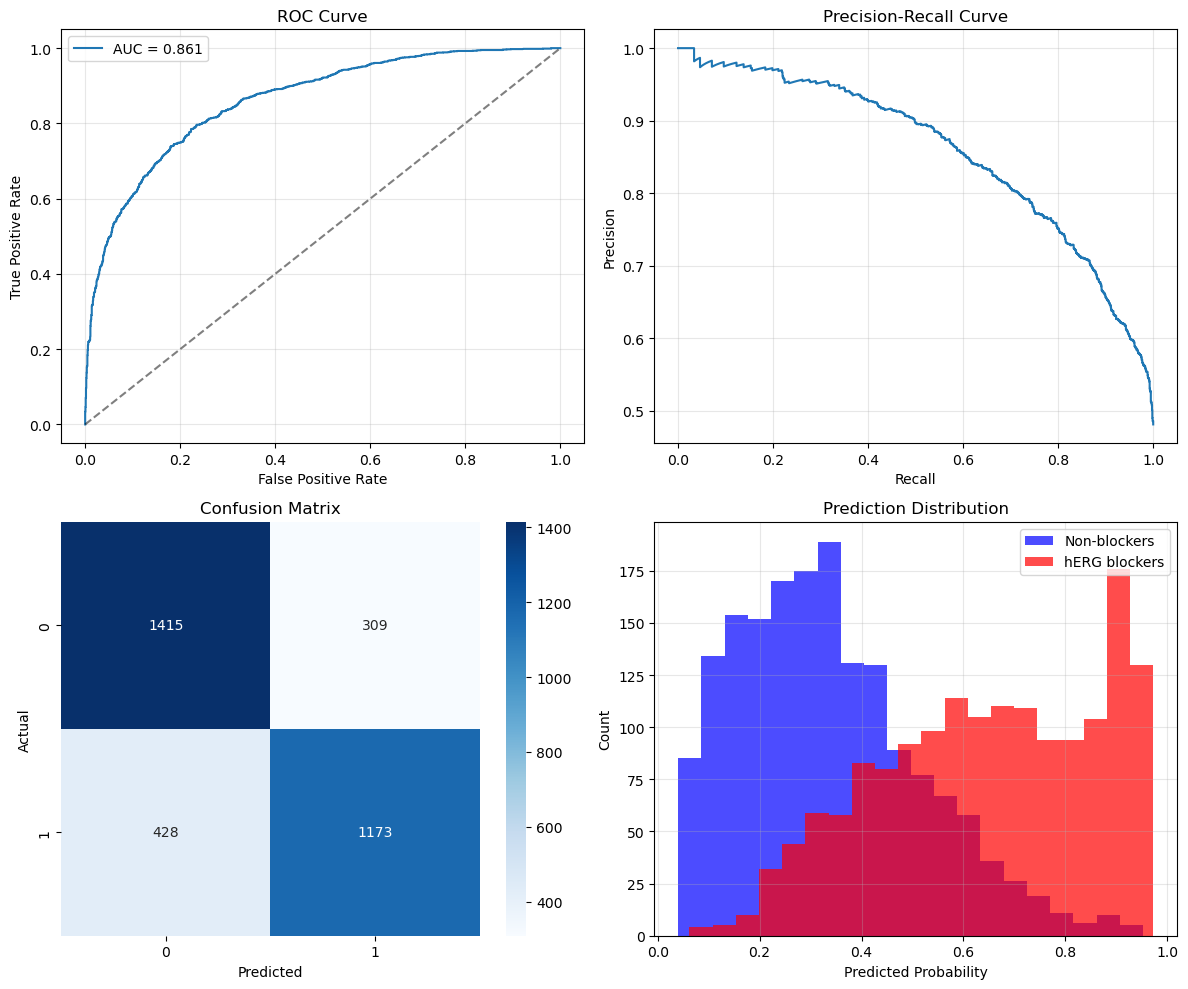

Evaluation plots saved as 'herg_model_evaluation_xgb.png'

Example Predictions:
--------------------------------------------------
SMILES: CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
Prediction: hERG blocker
Probability: 0.860
Risk Level: High risk
------------------------------
SMILES: CC(=O)Nc1ccc(O)cc1
Prediction: Non-blocker
Probability: 0.240
Risk Level: Low risk
------------------------------
SMILES: CN1C=NC2=C1C(=O)N(C)C(=O)N2C
Prediction: Non-blocker
Probability: 0.271
Risk Level: Low risk
------------------------------
Model saved to herg_qsar_model.pkl
Model training and evaluation complete!
Check 'herg_model_evaluation.png' for detailed results.


In [3]:
model.set_model_type('xgb')
# Train the model
training_results = model.train(df, test_size=0.2, cv_folds=7)

# Evaluate the model
evaluation_results = model.evaluate_model(plot=True)

# Example predictions
test_molecules = [
    'CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12',  # Likely hERG blocker
    'CC(=O)Nc1ccc(O)cc1',                  # Likely non-blocker (acetaminophen)
    'CN1C=NC2=C1C(=O)N(C)C(=O)N2C',       # Likely non-blocker (caffeine)
]

print("\nExample Predictions:")
print("-" * 50)
predictions = model.predict(test_molecules)

for pred in predictions:
    print(f"SMILES: {pred['smiles']}")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']:.3f}")
    print(f"Risk Level: {pred['risk_level']}")
    print("-" * 30)

# Save the model
model.save_model('herg_qsar_model.pkl')

print("Model training and evaluation complete!")
print("Check 'herg_model_evaluation.png' for detailed results.")


In [ ]:
assert 0

In [ ]:
model.set_model_type('svm')
# Train the model
training_results = model.train(df, test_size=0.2, cv_folds=7)

# Evaluate the model
evaluation_results = model.evaluate_model(plot=True)

# Example predictions
test_molecules = [
    'CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12',  # Likely hERG blocker
    'CC(=O)Nc1ccc(O)cc1',                  # Likely non-blocker (acetaminophen)
    'CN1C=NC2=C1C(=O)N(C)C(=O)N2C',       # Likely non-blocker (caffeine)
]

print("\nExample Predictions:")
print("-" * 50)
predictions = model.predict(test_molecules)

for pred in predictions:
    print(f"SMILES: {pred['smiles']}")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']:.3f}")
    print(f"Risk Level: {pred['risk_level']}")
    print("-" * 30)

# Save the model
model.save_model('herg_qsar_model.pkl')

print("Model training and evaluation complete!")
print("Check 'herg_model_evaluation.png' for detailed results.")


Model type set to svm. Please retrain the model.
Training SVM model with morgan fingerprints...
Training model...


In [ ]:
assert 0

In [ ]:
# model.set_model_type('svm') 
# Train the model
training_results = model.train(df, test_size=0.2, cv_folds=7)

# Evaluate the model
evaluation_results = model.evaluate_model(plot=True)

# Example predictions
test_molecules = [
    'CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12',  # Likely hERG blocker
    'CC(=O)Nc1ccc(O)cc1',                  # Likely non-blocker (acetaminophen)
    'CN1C=NC2=C1C(=O)N(C)C(=O)N2C',       # Likely non-blocker (caffeine)
]

print("\nExample Predictions:")
print("-" * 50)
predictions = model.predict(test_molecules)

for pred in predictions:
    print(f"SMILES: {pred['smiles']}")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']:.3f}")
    print(f"Risk Level: {pred['risk_level']}")
    print("-" * 30)

# Save the model
model.save_model('herg_qsar_model.pkl')

print("Model training and evaluation complete!")
print("Check 'herg_model_evaluation.png' for detailed results.")
